In [2]:
from keras.models import Sequential
#from keras.layers import LSTM, Dense
from keras.layers import Merge
from keras.optimizers import SGD
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import colors
from keras.models import model_from_json
%matplotlib inline

from keras.layers.core import Dense, Activation, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras import optimizers


In [3]:
def save_current_keras_model_json_hdf5(model, model_name):
    
    # serialize model architecture to json
    model_json = model.to_json()
    with open(model_name + '.json', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model metadata to json format: ', model_name + '.json')

    # serialize model weights to HDF5
    model.save_weights(model_name + '.h5')
    print('Saved model to h5 format: ', model_name + '.h5')

def load_keras_model(model_name):
    # inspired by:
    # http://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name + '.h5')
    print("Loaded model from disk")
    return loaded_model  

In [4]:
def spiral(theta_pi_scale, N, r0, xmax, xmin, ymin, ymax):
    x = []
    y = []
    max_r = theta_pi_scale*np.pi*theta_pi_scale*np.pi + r0
    for theta in np.linspace(0,theta_pi_scale*np.pi,N):
        r = r0 + ((theta)**2)
        x.append(r*np.cos(theta)/max_r)
        y.append(r*np.sin(theta)/max_r)

    x = np.asarray(x)
    y = np.asarray(y)
    x += 1; 
    y += 1

    x = xmin + x*(xmax-xmin)/(x.max())
    y = ymin + y*(ymax-ymin)/(y.max())        
    
    return np.asarray(x), np.asarray(y)

def linline(xmin,xmax,N, a, b):    
    x = np.linspace(xmin,xmax,N)
    y = a*x + b
    x_out = []
    y_out = []
    for i,xyi in enumerate(zip(x,y)):
        if xyi[1] > xmin and xyi[1] < xmax:
            x_out.append(xyi[0])
            y_out.append(xyi[1])
    return np.asarray(x_out), np.asarray(y_out)

def map_line_pattern2grid(x_pat,y_pat, dx, dy):
    
    
    x_pat_grid = np.round((x_pat/dx)).astype(int)
    y_pat_grid = np.round((y_pat/dy)).astype(int)
    
    return x_pat_grid, y_pat_grid

def greate_grid(xmin, xmax, dx, ymin, ymax, dy):
    
    x = np.arange(xmin, xmax+dx, dx)
    y = np.arange(ymin, ymax+dy, dy)
    xx_grid, yy_grid = np.meshgrid(x, y, sparse=False)        
    
    return xx_grid.astype(int), yy_grid.astype(int)

def grid_dict(x, y, xi, yi, dictIn = {}, TargetID = -1, timesteps = 0, verb = 1, mask_val = []):
    
    # append target information to grid dictionary
    # keys - str(row_n) + '_' str(col_n)
    # values: [x,y,TargetID,SequenceNo,SeqTag] - all floats
    repl_count = 0
    for k,(i,j) in enumerate(zip(xi,yi)):
        if len(mask_val) == len(x):
            TargetID = mask_val[k]
        if i < 0 or j < 0:
            print('Warning - NEGATIVE index ',i,j)
        key = str(i) + '_' + str(j)
        if key in dictIn.keys():
            repl_count += 1
            if verb == 1:
                print('replacing key: ', key, repl_count)
        if timesteps > 0:
            dictIn[key] = [x[k],y[k],TargetID,k,np.mod(k,timesteps)+1,i,j]
        else:
            dictIn[key] = [x[k],y[k],TargetID,k,0,i,j]
    return dictIn

def ini_grid_dict(xx_grid, yy_grid):
    # Target ID: -1 grid cells no detection
    # Target ID: 0 grid cells false detection
    # Target ID > 0 - target number
    x = xx_grid[0,:]
    i = []
    xi = np.asarray([i for i in range(xx_grid.shape[1])])
    # yiv = np.asarray([i for i in range(0,len(x))])
    y = yy_grid[:,0]
    #TargetID = -1
    #timesteps = 0
    dictIn = {}

    for yi in range(yy_grid.shape[0]):
        #yiv[:] = np.array(yi).copy()
        yiv = []
        for t in range(yy_grid.shape[0]):
            yiv.append(yi)
        yiv = np.asarray(yiv).flatten()        

        yv = []
        for t in range(len(y)):
            yv.append(y[yi])
        yv = np.asarray(yv).flatten()        
        dictIn = grid_dict(x, yv, xi, yiv, dictIn = dictIn, TargetID = -1, timesteps = 0)  
    return dictIn

def get_target_track(dictIn, TargetID, Nx, Ny):  
    
    xy = []
    for i in range(Nx):
        for j in range(Ny):
            key = str(i) + '_' + str(j)
            a = dictIn[key]
            if a[2] == TargetID:
                if len(xy) == 0:
                    xy = np.transpose(a)
                else:
                    xy = np.vstack((xy,np.transpose(a)))
    return xy

def get_all_data(dictIn, Nx, Ny, TargetID = -1):
        
    xy = []
    for i in range(Nx):
        for j in range(Ny):
            key = str(i) + '_' + str(j)
            a = dictIn[key]
            if a[2] != TargetID:
                if len(xy) == 0:
                    xy = np.transpose(a)
                else:
                    xy = np.vstack((xy,np.transpose(a)))
    return xy

def get_mask_from_all_dat(xx_grid, xy):
        
    mask_dat = np.zeros((xx_grid.shape[0],xx_grid.shape[1]))
    noise_mask_dat = np.zeros((xx_grid.shape[0],xx_grid.shape[1]))
    all_det_mask_dat = np.zeros((xx_grid.shape[0],xx_grid.shape[1]))
        
    for t in range(xy.shape[0]):
        j = xy[t,5].astype(int) # column number x
        i = xy[t,6].astype(int) # row    number y
        if xy[t,2] > 0:
            all_det_mask_dat[i,j] = 1
        if xy[t,2] > 1:
            mask_dat[i,j] = 1
        if xy[t,2] == 1:
            noise_mask_dat[i,j] = 1

    return mask_dat, noise_mask_dat, all_det_mask_dat
            

def get_images_from_masked_dat(mask, dxn = 3, dxn_overlap = 2):
    
    imhight = mask.shape[0] # number of rows
    imwidth = mask.shape[1] # number of columns
    ims = np.zeros((1000,dxn*imhight))
    y = np.zeros((1000,1))
    count = -1
    for i in range(0,ims.shape[1],dxn_overlap):
        if i+dxn > mask.shape[1]:
            break
        count += 1
        im = mask[:,i:i+dxn]
        # print(im.shape)
        ims[count,:] = np.reshape(im, (1,ims.shape[1]))
        y[count] = im.sum()
    
    return ims[:count+1,:], y[:count+1]

def get_3D_images_from_masked_dat(mask, dxn = 3, dxn_overlap = 2):
    
    imhight = mask.shape[0] # number of rows
    imwidth = mask.shape[1] # number of columns
    N = 100*imwidth
    ims = np.zeros((N,dxn,imhight))
    y = np.zeros((N,1))
    count = -1
    for i in range(0,imwidth,dxn_overlap):
        #print(i,i+dxn)
        if i+dxn > (mask.shape[1]+1):
            break
        count += 1
        im = mask[:,i:i+dxn].transpose()
        ims[count,:,:] = im 
        y[count] = im.sum()

    return ims[:count+1,:], y[:count+1]

def reduced_binary_noise_mask(N = 100):
    
    mask1_1 = np.random.randint(0,2,size=(N,N))
    mask2_1 = np.random.randint(0,2,size=(N,N))
    mask3_1 = np.random.randint(0,2,size=(N,N))
    maskOut = np.zeros(mask2_1.shape)
    for i in range(mask1_1.shape[0]):
        for j in range(mask1_1.shape[1]):
            if mask1_1[i,j]==1 and mask2_1[i,j]==1 and mask3_1[i,j]==1:
                #if mask1[i,j]==1 and mask2[i,j]==1 and mask3[i,j]==1:
                maskOut[i,j] = 1  
                
    return maskOut
def track_y_3D(y, n = 3):
    y_stacked = np.hstack((y,y))
    for i in range(n-2):
        y_stacked = np.hstack((y_stacked,y))
        
    return np.reshape(y_stacked,(y_stacked.shape[0],y_stacked.shape[1],1))
def get_noise_target_bin_class(y_noise_target, y_noise):
    y_target = np.zeros(y_noise_target.shape)
    for i in range(len(y_target)):
        if y_noise_target[i] > y_noise[i]:
            y_target[i] = 1
    return y_target


In [5]:
#train_X_lin.shape
#y_noise_target_lin1.shape
#y_noise_stack = np.vstack((y_noise,y_noise,y_noise,y_noise))
#y_noise_stack.shape
#im_noise_target_lin1.shape
def get_mapped_dat(mask, all_det_mask_dat, dxn, dxn_overlap):
    
    im_noise_target, y_noise_target= get_3D_images_from_masked_dat(all_det_mask_dat, dxn = dxn, dxn_overlap = dxn_overlap)
    im_noise, y_noise = get_3D_images_from_masked_dat(mask, dxn = dxn, dxn_overlap = dxn_overlap)
    return im_noise_target, y_noise_target, im_noise, y_noise


In [6]:
def get_data(xmin, xmax,ymin,ymax, dx, dy, N, scales, xx_grid2D, 
             yy_grid2D, xx_grid1D, yy_grid1D, linFlag, N_mask, dxn, dxn_overlap):
    
    if linFlag == True:
        a = scales[0]
        b = scales[1]
        x,y = linline(xmin,xmax,N, a, b)
    else:
        theta_pi_scale = scales[0]
        r0 = scales[1]
        y, x = spiral(theta_pi_scale, N, r0 ,xmax,xmin,ymax,ymin)
    # print(len(x),len(y))
    x_grid, y_grid = map_line_pattern2grid(x,y, dx, dy)
    
    mask = reduced_binary_noise_mask(N = N_mask)
    mask_val = mask.reshape((N_mask*N_mask,1)).astype(int).flatten()    
    
    dictIn1 = grid_dict(xx_grid1D, yy_grid1D, xx_grid1D, yy_grid1D, dictIn = {}, TargetID = 0, 
                   timesteps = 0, mask_val = mask_val)
    dictIn = grid_dict(x, y, x_grid, y_grid, dictIn = dictIn1.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
    xy = get_all_data(dictIn, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)    
    
    mask_dat, noise_mask_dat, all_det_mask_dat = get_mask_from_all_dat(xx_grid2D, xy)
    
        
    
    im_noise_target, y_noise_target, im_noise, y_noise = get_mapped_dat(mask,
                                    all_det_mask_dat, dxn, dxn_overlap)
    
    return im_noise_target, y_noise_target, im_noise, y_noise



In [7]:
def get_formated_dat(Npoints, Nblocks, N_mask, scales_bounds, linFlagV, dxn, dxn_overlap):
    
    
    X = []
    y = []
    theta_pi_scale_min = scales_bounds[0]
    theta_pi_scale_max = scales_bounds[1]
    r0_min = scales_bounds[2]
    r0_max = scales_bounds[3]
    scales = np.zeros((1,2)).flatten()
    assert Nblocks == len(linFlagV) 
    assert len(scales_bounds) == 4
    xmax = N_mask #mask1.shape[0]; 
    ymax = N_mask #mask1.shape[1]
    xmin = 0
    ymin = 0

    dx = (xmax-xmin)/N_mask
    dy = (ymax-ymin)/N_mask
    # create N x N grids
    xx_grid2D, yy_grid2D = greate_grid(xmin, xmax-1, dx, ymin, ymax-1, dy)
    xx_grid1D = xx_grid2D.reshape((N_mask*N_mask,1)).astype(int).flatten()
    yy_grid1D = yy_grid2D.reshape((N_mask*N_mask,1)).astype(int).flatten()

    for i in range(Nblocks):
        linFlag = linFlagV[i]
        if linFlag == True:
            a, b = np.random.randn(1), np.random.randint(10,90)
            scales[0] = a[0]
            scales[1] = b

        else:
            scales[0] = theta_pi_scale_min + np.random.rand(1)*theta_pi_scale_max
            scales[1] = r0_min + np.random.rand(1)*r0_max 

        im_noise_target, y_noise_target, im_noise, y_noise = get_data(xmin,xmax,ymin,ymax,
                dx, dy, Npoints, scales, xx_grid2D, yy_grid2D, xx_grid1D, yy_grid1D, 
                                                    linFlag, N_mask, dxn, dxn_overlap)                                                                      
        # print(im_noise_target.shape)
        target_class = get_noise_target_bin_class(y_noise_target, y_noise)
        
        noiseFlag1 = np.random.randint(0,2,1)
        noiseFlag2 = np.random.randint(0,2,1)
        if noiseFlag1 == 0 and noiseFlag2 == 0:
            y1 = np.zeros(y_noise.shape)
            X1 = im_noise
            #print('NaN,NaN')
        else:
            #print(scales)
            y1 = target_class
            X1 = im_noise_target
        #y1 = np.vstack((target_class, np.zeros(y_noise.shape)))
        #X1 = np.vstack((im_noise_target,im_noise))
        if len(X) == 0:
            X = X1
            y = y1
        else:
            X = np.vstack((X, X1))
            y = np.vstack((y,y1))

    return X, y

    

In [8]:
def imconcat(X, ni, nstep):
    X_out = []
    for i in range(ni, ni+nstep):
        if len(X_out) == 0:
            X_out = X[i,:,:]
        else:
            X_out = np.vstack((X_out, X[i,:,:]))
    return X_out
    
def image_plot(X, ni,nstep):
    fig=plt.figure(figsize=(15,12))
    #gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    cmap = colors.ListedColormap(['white','black'])
    ind = 0
    for j in range(ni, ni+nstep*4, nstep):
        #print(j)
        if j > X.shape[0]-nstep:
            break
        X2 = imconcat(X, j, nstep)
        ind += 1
        plt.subplot(2,2,ind)
        plt.imshow(X2.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto')

def load_data(DATA_PATH, fname_start, no_files):
    
    X = []
    y = []

    for i in range(no_files):
        xfname = DATA_PATH+fname_start + '_X_' + str(file_no) + '.npy'
        yfname = DATA_PATH+fname_start + '_y_' + str(file_no) + '.npy'
        X1 = np.load(xfname)
        y1 = np.load(yfname)
        if len(X) == 0:
            X = X1
            y = y1
        else:
            X = np.vstack((X,X1))
            y = np.vstack((y,y1))
    return X, y

def save_dat(DATA_PATH, fname_start, X,y, file_no):
    
    xfname = DATA_PATH+fname_start + '_X_' + str(file_no) + '.npy'
    yfname = DATA_PATH+fname_start + '_y_' + str(file_no) + '.npy'
    np.save(xfname, X)
    np.save(yfname, y)

In [112]:
def roc_dat(estim_Y, Y_mixed_test1, th):
    
    time_steps = 1
    a_1 = np.zeros(estim_Y.shape[0]*time_steps)
    a_2 = np.zeros(estim_Y.shape[0]*time_steps)

    a = np.zeros(estim_Y.shape[0]*time_steps)
    b = np.zeros(estim_Y.shape[0]*time_steps)
    c = np.zeros(estim_Y.shape[0]*time_steps)
    d =  np.zeros(estim_Y.shape[0]*time_steps)

    count = -1
    for i in range(estim_Y.shape[0]):
        count += 1
        if estim_Y[i] > th:
            a_2[count] = 1
        if Y_mixed_test1[i] > th:
            a_1[count] = 1
        if estim_Y[i] > th and Y_mixed_test1[i] > th:
            a[count] = 1 # true positive
        if estim_Y[i] < th and Y_mixed_test1[i] > th:
            b[count] = 1 # false negative
        if estim_Y[i] > th and Y_mixed_test1[i] < th:
            c[count] = 1 # false positive
        if estim_Y[i] < th and Y_mixed_test1[i] < th:
            d[count] = 1 # true negative
        
    #print(estim_Y.shape)
    #print(train_X1.shape)
    print('Pd  ' ,sum(a)/(sum(a)+sum(b)), 'True Pos:  ', sum(a_2), 'Estim Pos: ', sum(a_1))
    print('P_false_pos_rate  ',  1 - sum(d)/(sum(c)+sum(d)))


    res1 = 1 - np.sum(np.abs(np.round(Y_mixed_test1[:]) - np.round( estim_Y[:]))/estim_Y.shape[0])
    print(np.sum(np.abs(Y_mixed_test1- estim_Y))/len(Y_mixed_test1[:,0])*100)
    print(res1*100)


In [118]:
DATA_PATH = 'data/'

In [ ]:
#np.random.seed(12345)
#np.random.seed(1234)
#np.random.seed(7)

timesteps = 5 #10
dxn_overlap = 10
dxn = 10
seqlen = 2
batch_size = 5

xmin = 0; ymin = 0
scales_bounds = [3, 7, 50, 300]
Nblocks = 2*500 #2*250
Npoints = 300
N_mask = 30#100
linFlagV = np.ones((Nblocks,1))
fname_start = 'train_linear'
no_files = 2
load_data_flag = False
# linFlagV[2:5] = 0
if load_data_flag == True:
    X,y = load_data(DATA_PATH, fname_start, no_files)
else:
    X, y = get_formated_dat(Npoints, Nblocks, N_mask, scales_bounds, linFlagV, dxn, dxn_overlap)
    file_no = 3
    save_dat(DATA_PATH, fname_start, X,y, file_no)
print(X.shape, y.shape)



In [119]:
def y_to_yplot(y, dx):
    y_plot = []
    for i in range(len(y)):
        y1 = np.ones((dx,1))*y[i]
        if len(y_plot) == 0:
            y_plot = y1
        else:
            y_plot = np.vstack((y_plot,y1))
    return np.array(y_plot).flatten()

(30000,) (3000, 1) (3000, 10, 30)


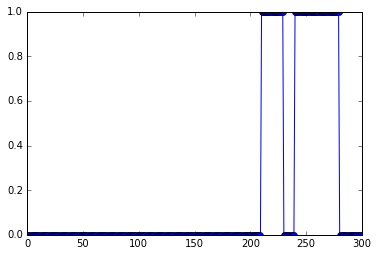

In [120]:
#yfname_train = DATA_PATH+'train_linear_y_2.npy'
#np.save(yfname_train, y)
#save_dat(DATA_PATH, fname_start, X,y, file_no)
y_plot = y_to_yplot(y, dxn)
plt.plot(y_plot[600:900],'o-')
print(y_plot.shape, y.shape, X.shape)

In [121]:
Nblocks_test = 100
linFlagV_test = np.ones((Nblocks_test,1))
test_X, test_y_true = get_formated_dat(Npoints, Nblocks_test, N_mask, scales_bounds, linFlagV_test, dxn, dxn_overlap)

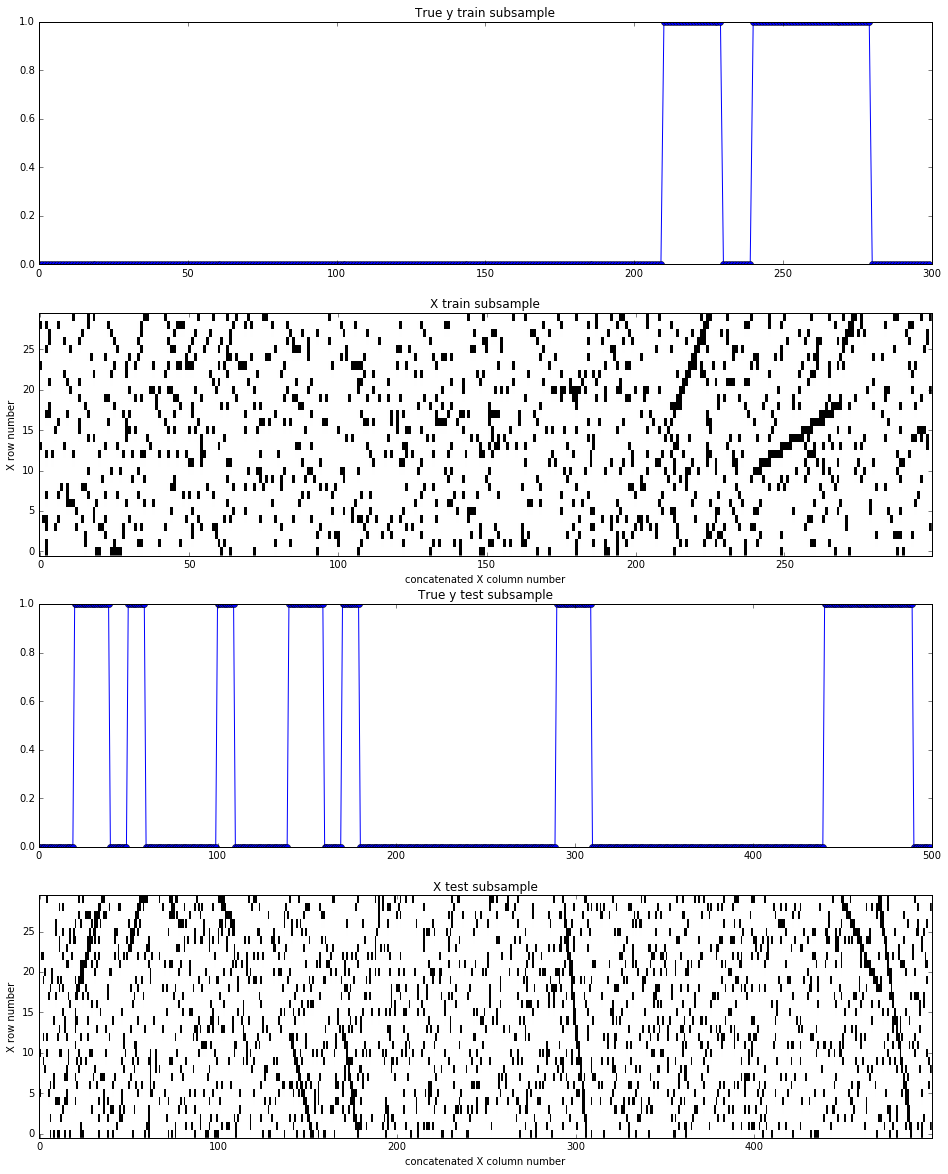

In [122]:
#ims, y_noise_target = get_3D_images_from_masked_dat(all_det_mask_dat, dxn = 10, dxn_overlap = 10)
#from matplotlib import gridspec
y_plot = y_to_yplot(y, dxn)
test_y_true_plot = y_to_yplot(test_y_true, dxn)
fig=plt.figure(figsize=(16,20))
cmap = colors.ListedColormap(['white','black'])
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.subplot(4,1,1)
plt.plot(y_plot[600:900],'o-')
plt.title('True y train subsample')
plt.subplot(4,1,2)
#ims = X[60:140,:,:].copy()
ims = X[60:90,:,:].copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.title('X train subsample')
plt.xlabel('concatenated X column number')
plt.ylabel('X row number')
plt.subplot(4,1,3)
plt.plot(test_y_true_plot[1000:1500],'o-')
plt.title('True y test subsample')
plt.subplot(4,1,4)
ims = test_X[100:150,:,:].copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.title('X test subsample')
plt.xlabel('concatenated X column number')
plt.ylabel('X row number')

In [123]:
input_shape = (X.shape[1],X.shape[2])
print('Build model...')
hidden_size = 16
K.reset_uids()
K.clear_session()
model_lin = Sequential()
#model.add(Masking(mask_value=0))
#model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False))
model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=True))
model_lin.add(Dense(hidden_size))
model_lin.add(Activation('relu'))

#model_lin.add(Dense(output_dim=1, activation="linear"))
model_lin.add(Dense(output_dim=1, activation="relu"))
model_lin.summary()
#optimizer = optimizers.rmsprop(lr=0.01, clipnorm=2)
#model_lin.compile(optimizer=optimizer, loss='mse')
optimizer = optimizers.Adam(clipnorm=2)

model_lin.compile(optimizer=optimizer, loss='binary_crossentropy')
# model_lin.compile(optimizer=optimizer, loss='mse')

# kullback_leibler_divergence
# from keras.utils.np_utils import to_categorical
#categorical_labels = to_categorical(int_labels, num_classes=None)
# from keras import losses
# model.compile(loss=losses.mean_squared_error, optimizer='sgd')

Build model...


/home/george/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=16, input_shape=(10, 30), return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 16)            3008      
_________________________________________________________________
dense_1 (Dense)              (None, 10, 16)            272       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 16)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 1)             17        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


/home/george/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="relu")`


In [124]:
#model_lin.fit(X, y, epochs = 100)
batch_size = 3
y3D = track_y_3D(y.copy(), n = 10)
model_lin.fit(X, y3D, epochs = 200, batch_size = batch_size, verbose = 1, shuffle=True)
#model_lin.fit(X, y3D, epochs = 200, batch_size = batch_size, verbose = 1, shuffle=False)

Epoch 1/200
3000/3000 [==============================] - 11s - loss: 0.6853    
Epoch 2/200
3000/3000 [==============================] - 10s - loss: 0.7369    
Epoch 3/200
3000/3000 [==============================] - 10s - loss: 0.7062    
Epoch 4/200
3000/3000 [==============================] - 11s - loss: 0.6561    
Epoch 5/200
3000/3000 [==============================] - 11s - loss: 0.6115    
Epoch 6/200
3000/3000 [==============================] - 11s - loss: 0.5560    
Epoch 7/200
3000/3000 [==============================] - 11s - loss: 0.6008    
Epoch 8/200
3000/3000 [==============================] - 11s - loss: 0.5639    
Epoch 9/200
3000/3000 [==============================] - 11s - loss: 0.5544    
Epoch 10/200
3000/3000 [==============================] - 11s - loss: 0.5095    
Epoch 11/200
3000/3000 [==============================] - 11s - loss: 0.5137    
Epoch 12/200
3000/3000 [==============================] - 11s - loss: 0.4858    
Epoch 13/200
3000/3000 [=============

KeyboardInterrupt: 

In [85]:
fname_start = 'test_linear'
file_no = 1
Nblocks_test = 100
linFlagV_test = np.ones((Nblocks_test,1))
test_X, test_y_true = get_formated_dat(Npoints, Nblocks_test, N_mask, scales_bounds, linFlagV_test, dxn, dxn_overlap)
#save_dat(DATA_PATH, fname_start, test_X,test_y_true, file_no)
test_X.shape
#pickle.dump?

(300, 10, 30)

In [86]:
#import pickle              # import module first

#fname_test = DATA_PATH+'test_linear_X.npy'
#test_X = np.load(fname)
print(test_X.shape, Y_estim_test.shape, X.shape)


(300, 10, 30) (300, 1) (1500, 10, 30)


In [125]:
train_X = X.copy()
#test_X = X.copy()
#test_y_true = y.copy()
train_y_true = y.copy()

Y_estim_train = model_lin.predict(train_X, batch_size = batch_size)
Y_estim_test = model_lin.predict(test_X, batch_size = batch_size)


In [126]:
Y_estim_train=Y_estim_train.sum(axis=1)/Y_estim_train.shape[1]
Y_estim_test=Y_estim_test.sum(axis=1)/Y_estim_test.shape[1]
#print(y[:5].transpose())
#a.shape

In [127]:
#Y_estim_test[Y_estim_test == 0.5]=1
Y_estim_test[Y_estim_test < 0.5]=0
Y_estim_test[Y_estim_test >= 0.5]=1

#Y_estim_train[Y_estim_train == 0.5]=1
Y_estim_train[Y_estim_train < 0.5]=0
Y_estim_train[Y_estim_train >= 0.5]=1

In [128]:
print(np.sum(np.abs(test_y_true - Y_estim_test))/len(test_y_true[:,0])*100)
print(np.sum(np.abs(train_y_true - Y_estim_train))/len(train_y_true[:,0])*100)
#print(np.sum(np.abs(test_y_true - Y_estim_test[:,0,0]))/len(test_y_true[:,0])*100)
#print(np.sum(np.abs(train_y_true - Y_estim_train[:,0,0]))/len(train_y_true[:,0])*100)
roc_dat(Y_estim_test, test_y_true, 0.5)

17.6666666667
0.466666666667
Pd   0.628571428571 True Pos:   71.0 Estim Pos:  70.0
P_false_pos_rate   0.117391304348
17.6666666667
82.3333333333


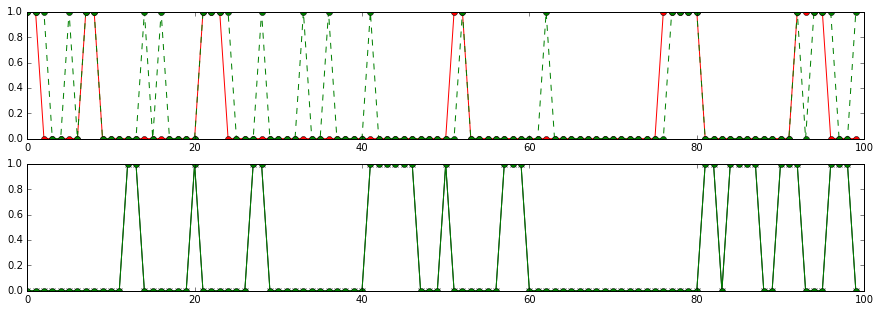

In [129]:
n1=0; n2 = 100#len(test_y_true)
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(test_y_true[n1:n2,0],'r-o')
plt.plot(Y_estim_test[n1:n2],'go--')
plt.subplot(2,1,2)
plt.plot(train_y_true[:100,0],'k-x')
plt.plot(Y_estim_train[:100],'go-')

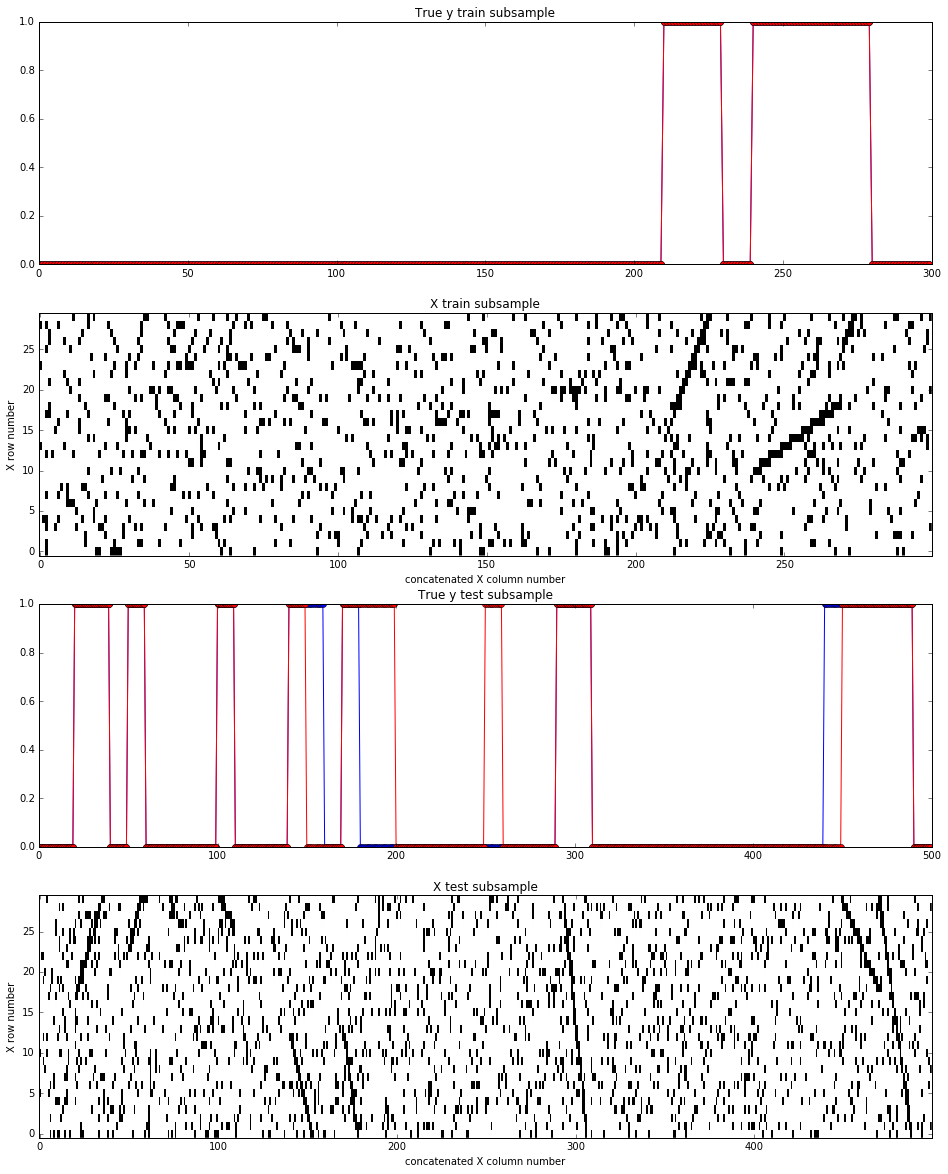

In [133]:
# y_plot = y_to_yplot(y, dxn)
test_y_true_plot = y_to_yplot(test_y_true, dxn)
test_y_estim_plot = y_to_yplot(Y_estim_test, dxn)

y_plot =  y_to_yplot(train_y_true, dxn)
train_y_estim_plot = y_to_yplot(Y_estim_train, dxn)

fig=plt.figure(figsize=(16,20))
cmap = colors.ListedColormap(['white','black'])
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.subplot(4,1,1)
plt.plot(y_plot[600:900],'o-');
plt.plot(train_y_estim_plot[600:900],'ro-');
plt.title('True y train subsample')
plt.subplot(4,1,2)
#ims = X[60:140,:,:].copy()
ims = X[60:90,:,:].copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.title('X train subsample')
plt.xlabel('concatenated X column number')
plt.ylabel('X row number')
plt.subplot(4,1,3)
plt.plot(test_y_true_plot[1000:1500],'o-');
plt.plot(test_y_estim_plot[1000:1500],'ro-');
plt.title('True y test subsample')
plt.subplot(4,1,4)
ims = test_X[100:150,:,:].copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.title('X test subsample')
plt.xlabel('concatenated X column number')
plt.ylabel('X row number')

In [134]:
X.shape

(3000, 10, 30)

In [135]:
model_name = DATA_PATH + 'keras_3k_dat_linmodel'
save_current_keras_model_json_hdf5(model_lin, model_name)

Saved model metadata to json format:  data/keras_3k_dat_linmodel.json
Saved model to h5 format:  data/keras_3k_dat_linmodel.h5


In [ ]:
dxx = 10
start = [0,40]
#dxx  = 20
#start = [0,80]
image_plot(X, start[0], dxx)
# prints images 0 - 3
image_plot(X, start[1], dxx)
# prints images 4 - 7

X.shape
#plt.imshow(X[0,:,:])
#plt.plot(y)

In [ ]:


# spiral track constants
theta_pi_scale = 5; N_sp = 300; r0 = 100;
scSp = 1.2
# linear track constants
N_lin = 200
a1 = 0.2;  b1 = 30 # respectively slope and bias
a2 = -0.7; b2 = 50
a3 = -0.4; b3 = 20
a4 = 0.5; b4 = 40

a5 = -0.15; b5 = 35
a6 = 0.85; b6 = 5 #43




    


In [ ]:

#print(np.random.randint(0,2,size=(2,2)))
N_mask = 100
mask1 = reduced_binary_noise_mask(N = N_mask)
mask2 = reduced_binary_noise_mask(N = N_mask)
mask3 = reduced_binary_noise_mask(N = N_mask)
#ims1, y1 = get_3D_images_from_masked_dat(mask1, dxn = 10, dxn_overlap = 10)
mask_val1 = mask1.reshape((N_mask*N_mask,1)).astype(int).flatten()
mask_val2 = mask2.reshape((N_mask*N_mask,1)).astype(int).flatten()
mask_val3 = mask3.reshape((N_mask*N_mask,1)).astype(int).flatten()

In [ ]:
print(ims1.shape)
np.alltrue(mask_val1 == mask_val2)

In [ ]:
timesteps = 5 #10
# spiral track constants
theta_pi_scale = 5; N_sp = 300; r0 = 100;
scSp = 1.2
# linear track constants
N_lin = 200
a1 = 0.2;  b1 = 30 # respectively slope and bias
a2 = -0.7; b2 = 50
a3 = -0.4; b3 = 20
a4 = 0.5; b4 = 40

a5 = -0.15; b5 = 35
a6 = 0.85; b6 = 5 #43

dxn_overlap = 15
dxn = 15
seqlen = 2
batch_size = 10

xmin = 0; ymin = 0
xmax = mask1.shape[0]; ymax = mask1.shape[1]

dx = (xmax-xmin)/N_mask; dy = (ymax-ymin)/N_mask
# create N x N grids
xx_grid2D, yy_grid2D = greate_grid(xmin, xmax-1, dx, ymin, ymax-1, dy)
xx_grid1D = xx_grid2D.reshape((N_mask*N_mask,1)).astype(int).flatten()
yy_grid1D = yy_grid2D.reshape((N_mask*N_mask,1)).astype(int).flatten()

y_sp1, x_sp1 = spiral(theta_pi_scale, N_sp, r0,xmax,xmin,ymax,ymin)
x_sp2, y_sp2 = spiral(theta_pi_scale, N_sp, r0,xmax,xmin,ymax,ymin)
y_sp3, x_sp3 = spiral(theta_pi_scale*scSp, N_sp, r0,xmax,xmin,ymax,ymin)
x_sp4, y_sp4 = spiral(theta_pi_scale*scSp, N_sp, r0,xmax,xmin,ymax,ymin)
#x_sp1 = x_sp1[:N_sp//9]
#y_sp1 = y_sp1[:N_sp//9]
#x_sp2 = x_sp2[:N_sp//9]
#y_sp2 = y_sp2[:N_sp//9]

x_lin1,y_lin1 = linline(xmin,xmax,N_lin, a1, b1)
x_lin2,y_lin2 = linline(xmin,xmax,N_lin, a2, b2)
x_lin3,y_lin3 = linline(xmin,xmax,N_lin, a3, b3)
x_lin4,y_lin4 = linline(xmin,xmax,N_lin, a4, b4)
x_lin5,y_lin5 = linline(xmin,xmax,N_lin, a5, b5)
x_lin6,y_lin6 = linline(xmin,xmax,N_lin, a6, b6)


x_lin_grid1, y_lin_grid1 = map_line_pattern2grid(x_lin1,y_lin1, dx, dy)
x_lin_grid2, y_lin_grid2 = map_line_pattern2grid(x_lin2,y_lin2, dx, dy)
x_lin_grid3, y_lin_grid3 = map_line_pattern2grid(x_lin3,y_lin3, dx, dy)
x_lin_grid4, y_lin_grid4 = map_line_pattern2grid(x_lin4,y_lin4, dx, dy)
x_lin_grid5, y_lin_grid5 = map_line_pattern2grid(x_lin5,y_lin5, dx, dy)
x_lin_grid6, y_lin_grid6 = map_line_pattern2grid(x_lin6,y_lin6, dx, dy)



x_sp_grid1, y_sp_grid1 = map_line_pattern2grid(x_sp1,y_sp1, dx, dy)
x_sp_grid2, y_sp_grid2 = map_line_pattern2grid(x_sp2,y_sp2, dx, dy)
x_sp_grid3, y_sp_grid3 = map_line_pattern2grid(x_sp3,y_sp3, dx, dy)
x_sp_grid4, y_sp_grid4 = map_line_pattern2grid(x_sp4,y_sp4, dx, dy)

dictIn1 = grid_dict(xx_grid1D, yy_grid1D, xx_grid1D, yy_grid1D, dictIn = {}, TargetID = 0, 
                   timesteps = 0, mask_val = mask_val1)
dictIn2 = grid_dict(xx_grid1D, yy_grid1D, xx_grid1D, yy_grid1D, dictIn = {}, TargetID = 0, 
                   timesteps = 0, mask_val = mask_val2)
dictIn3 = grid_dict(xx_grid1D, yy_grid1D, xx_grid1D, yy_grid1D, dictIn = {}, TargetID = 0, 
                   timesteps = 0, mask_val = mask_val3)

dictIn_lin1 = grid_dict(x_lin1, y_lin1, x_lin_grid1, y_lin_grid1, dictIn = dictIn1.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_lin2 = grid_dict(x_lin2, y_lin2, x_lin_grid2, y_lin_grid2, dictIn = dictIn1.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_lin3 = grid_dict(x_lin3, y_lin3, x_lin_grid3, y_lin_grid3, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_lin4 = grid_dict(x_lin4, y_lin4, x_lin_grid4, y_lin_grid4, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])


dictIn_lin5 = grid_dict(x_lin5, y_lin5, x_lin_grid5, y_lin_grid5, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_lin6 = grid_dict(x_lin6, y_lin6, x_lin_grid6, y_lin_grid6, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])

dictIn_sp1 = grid_dict(x_sp1, y_sp1, x_sp_grid1, y_sp_grid1, dictIn = dictIn1.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_sp2 = grid_dict(x_sp2, y_sp2, x_sp_grid2, y_sp_grid2, dictIn = dictIn1.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_sp3 = grid_dict(x_sp3, y_sp3, x_sp_grid3, y_sp_grid3, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])
dictIn_sp4 = grid_dict(x_sp4, y_sp4, x_sp_grid4, y_sp_grid4, dictIn = dictIn2.copy(), TargetID = 2, 
                   timesteps = timesteps, verb = 0, mask_val = [])

In [ ]:
{}.copy()

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(x_lin_grid1,y_lin_grid1,'b-x')
plt.plot(x_lin_grid2,y_lin_grid2,'b-o');
plt.plot(x_sp_grid1,y_sp_grid1,'b-x');
plt.plot(x_sp_grid2,y_sp_grid2,'b-o');
plt.title('Training data')

plt.subplot(1,2,2)

plt.plot(x_lin_grid3,y_lin_grid3,'r-x');
plt.plot(x_lin_grid4,y_lin_grid4,'r-o');
plt.plot(x_lin_grid5,y_lin_grid5,'r-x');
plt.plot(x_lin_grid6,y_lin_grid6,'r-o');

plt.plot(x_sp_grid3,y_sp_grid3,'r-x');
plt.plot(x_sp_grid4,y_sp_grid4,'r-o');
plt.title('Test data')

In [ ]:
xy_lin1 = get_all_data(dictIn_lin1, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_sp1 = get_all_data(dictIn_sp1, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_lin2 = get_all_data(dictIn_lin2, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_sp2 = get_all_data(dictIn_sp2, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)

xy_lin3 = get_all_data(dictIn_lin3, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_sp3 = get_all_data(dictIn_sp3, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_lin4 = get_all_data(dictIn_lin4, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_sp4 = get_all_data(dictIn_sp4, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)

xy_lin5 = get_all_data(dictIn_lin5, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)
xy_lin6 = get_all_data(dictIn_lin6, xx_grid2D.shape[0], xx_grid2D.shape[1], TargetID = -10)

mask_dat_lin1, noise_mask_dat_lin1, all_det_mask_dat_lin1 = get_mask_from_all_dat(xx_grid2D, xy_lin1)
mask_dat_sp1, noise_mask_dat_sp1, all_det_mask_dat_sp1 = get_mask_from_all_dat(xx_grid2D, xy_sp1)

mask_dat_lin2, noise_mask_dat_lin2, all_det_mask_dat_lin2 = get_mask_from_all_dat(xx_grid2D, xy_lin2)
mask_dat_sp2, noise_mask_dat_sp2, all_det_mask_dat_sp2 = get_mask_from_all_dat(xx_grid2D, xy_sp2)

mask_dat_lin3, noise_mask_dat_lin3, all_det_mask_dat_lin3 = get_mask_from_all_dat(xx_grid2D, xy_lin3)
mask_dat_sp3, noise_mask_dat_sp3, all_det_mask_dat_sp3 = get_mask_from_all_dat(xx_grid2D, xy_sp3)

mask_dat_lin4, noise_mask_dat_lin4, all_det_mask_dat_lin4 = get_mask_from_all_dat(xx_grid2D, xy_lin4)
mask_dat_sp4, noise_mask_dat_sp4, all_det_mask_dat_sp4 = get_mask_from_all_dat(xx_grid2D, xy_sp4)

mask_dat_lin5, noise_mask_dat_lin5, all_det_mask_dat_lin5 = get_mask_from_all_dat(xx_grid2D, xy_lin5)
mask_dat_lin6, noise_mask_dat_lin6, all_det_mask_dat_lin6 = get_mask_from_all_dat(xx_grid2D, xy_lin6)


In [ ]:
def plot_train_data(noise_mask_dat_lin, mask_dat_lin, all_det_mask_dat_lin, 
                    noise_mask_dat_sp, mask_dat_sp, all_det_mask_dat_sp,xmin,xmax,ymin,ymax):
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    cmap = colors.ListedColormap(['white','black'])
    plt.imshow(noise_mask_dat_lin,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cmap = colors.ListedColormap(['white','black'])
    plt.subplot(2,3,2)
    plt.imshow(mask_dat_lin,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.subplot(2,3,3)
    plt.imshow(all_det_mask_dat_lin,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.subplot(2,3,4)
    cmap = colors.ListedColormap(['white','black'])
    plt.imshow(noise_mask_dat_sp,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cmap = colors.ListedColormap(['white','black'])
    plt.subplot(2,3,5)
    plt.imshow(mask_dat_sp,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.subplot(2,3,6)
    plt.imshow(all_det_mask_dat_sp,origin='lower', cmap=cmap, interpolation = 'none');
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

In [ ]:
plot_train_data(noise_mask_dat_lin1, mask_dat_lin1, all_det_mask_dat_lin1, 
                    noise_mask_dat_sp1, mask_dat_sp1, all_det_mask_dat_sp1,xmin,xmax,ymin,ymax)

In [ ]:
plot_train_data(noise_mask_dat_lin4, mask_dat_lin4, all_det_mask_dat_lin4, 
                    noise_mask_dat_sp4, mask_dat_sp4, all_det_mask_dat_sp4,xmin,xmax,ymin,ymax)

im_noise_target_lin1, y_noise_target_lin1 = get_3D_images_from_masked_dat(all_det_mask_dat_lin1, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise_target_sp1, y_noise_target_sp1 = get_3D_images_from_masked_dat(all_det_mask_dat_sp1, dxn = dxn, dxn_overlap = dxn_overlap)

im_noise_target_lin2, y_noise_target_lin2 = get_3D_images_from_masked_dat(all_det_mask_dat_lin2, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise_target_sp2, y_noise_target_sp2 = get_3D_images_from_masked_dat(all_det_mask_dat_sp2, dxn = dxn, dxn_overlap = dxn_overlap)

im_noise_target_lin3, y_noise_target_lin3 = get_3D_images_from_masked_dat(all_det_mask_dat_lin3, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise_target_sp3, y_noise_target_sp3 = get_3D_images_from_masked_dat(all_det_mask_dat_sp3, dxn = dxn, dxn_overlap = dxn_overlap)

im_noise_target_lin4, y_noise_target_lin4 = get_3D_images_from_masked_dat(all_det_mask_dat_lin4, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise_target_sp4, y_noise_target_sp4 = get_3D_images_from_masked_dat(all_det_mask_dat_sp4, dxn = dxn, dxn_overlap = dxn_overlap)


im_noise1, y_noise1 = get_3D_images_from_masked_dat(mask1, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise2, y_noise2 = get_3D_images_from_masked_dat(mask2, dxn = dxn, dxn_overlap = dxn_overlap)
im_noise3, y_noise3 = get_3D_images_from_masked_dat(mask3, dxn = dxn, dxn_overlap = dxn_overlap)


In [ ]:
im_noise_target_lin1, y_noise_target_lin1, im_noise1, y_noise1 = get_mapped_dat(mask1, 
                                                                              all_det_mask_dat_lin1, dxn, dxn_overlap)
im_noise_target_lin2, y_noise_target_lin2, _, _ = get_mapped_dat(mask1, 
                                                                              all_det_mask_dat_lin2, dxn, dxn_overlap)
im_noise_target_lin3, y_noise_target_lin3, im_noise2, y_noise2 = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_lin3, dxn, dxn_overlap)
im_noise_target_lin4, y_noise_target_lin4, _, _ = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_lin4, dxn, dxn_overlap)

im_noise_target_lin5, y_noise_target_lin5, _, _ = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_lin5, dxn, dxn_overlap)
im_noise_target_lin6, y_noise_target_lin6, _, _ = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_lin6, dxn, dxn_overlap)


im_noise_target_sp1, y_noise_target_sp1, _, _ = get_mapped_dat(mask1, 
                                                                              all_det_mask_dat_sp1, dxn, dxn_overlap)
im_noise_target_sp2, y_noise_target_sp2, _, _ = get_mapped_dat(mask1, 
                                                                              all_det_mask_dat_sp2, dxn, dxn_overlap)
im_noise_target_sp3, y_noise_target_sp3, im_noise2, y_noise2 = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_sp3, dxn, dxn_overlap)
im_noise_target_sp4, y_noise_target_sp4, _, _ = get_mapped_dat(mask2, 
                                                                              all_det_mask_dat_sp4, dxn, dxn_overlap)

im_noise3, y_noise3 = get_3D_images_from_masked_dat(mask3, dxn = dxn, dxn_overlap = dxn_overlap)

In [ ]:
print(mask1.sum(), mask2.sum(), mask3.sum())
plt.plot(mask1.sum(axis=0))
plt.plot(mask2.sum(axis=0))
plt.plot(mask3.sum(axis=0))

In [ ]:
from matplotlib import gridspec
fig=plt.figure(figsize=(15,12))
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
cmap = colors.ListedColormap(['white','black'])
plt.subplot(2,2,1)
ims = im_noise_target_sp1.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto')
plt.subplot(2,2,2)
ims = im_noise_target_sp2.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto')

plt.subplot(2,2,3)
ims = im_noise_target_sp3.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto')
plt.subplot(2,2,4)
ims = im_noise_target_sp4.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto')

In [ ]:
train_X = np.vstack((im_noise_target_lin1,im_noise1,im_noise_target_lin2,im_noise1, 
                         im_noise_target_lin3,im_noise2, im_noise_target_lin4,im_noise2,
                    im_noise_target_sp1,im_noise2, im_noise_target_sp2, im_noise2))

train_X_noise = np.vstack((im_noise1, im_noise1, im_noise1, im_noise1,
                           im_noise2, im_noise2, im_noise2, im_noise2, 
                           im_noise2, im_noise2, im_noise2, im_noise2))

train_y_noise = np.vstack((y_noise1, y_noise1, y_noise1, y_noise1,
                           y_noise2, y_noise2, y_noise2, y_noise2, 
                           y_noise2, y_noise2, y_noise2, y_noise2))


In [ ]:

n1 = len(im_noise1)
n2 = len(im_noise2)
n3 = len(im_noise3)
zeros1 = np.zeros((n1,1))
zeros2 = np.zeros((n2,1))
zeros3 = np.zeros((n3,1))
ones1 = np.ones((n1,1))
ones2 = np.ones((n1,1))
ones3 = np.ones((n2,1))
ones4 = np.ones((n2,1))

train_y_true = np.vstack((ones1,zeros1,ones2,zeros1,
                             ones3,zeros2,ones4, zeros2,
                         ones1, zeros2,ones2, zeros2))


#test_X = np.vstack((im_noise3, im_noise_target_lin3,im_noise3, im_noise_target_lin4,
#                       im_noise3, im_noise_target_sp3,im_noise3, im_noise_target_sp4))

#test_X = np.vstack((im_noise3, im_noise_target_lin3,im_noise3, im_noise_target_lin4,
#                       im_noise3, im_noise_target_lin5,im_noise3, im_noise_target_lin6))

test_X = np.vstack((im_noise2, im_noise_target_lin3,im_noise2, im_noise_target_lin4,
                       im_noise2, im_noise_target_lin5,im_noise2, im_noise_target_lin6))

test_X_noise = np.vstack((im_noise3, im_noise3,im_noise3, im_noise3,
                       im_noise3,im_noise3, im_noise3, im_noise3))
test_y_noise = np.vstack((y_noise3, y_noise3, y_noise3, y_noise3,
                           y_noise3, y_noise3, y_noise3, y_noise3))

#test_y_true = np.vstack((y_noise3, y_noise_target_lin3,y_noise3,y_noise_target_lin4,
#                             y_noise3, y_noise_target_sp3, y_noise3,y_noise_target_sp4))
test_y_true = np.vstack((zeros3,ones3,zeros3,ones4,
                             zeros3,ones3, zeros3,ones4))



simple_sum_check = False
if simple_sum_check:
    test_y_true = np.vstack((y_noise3, y_noise_target_lin3,y_noise3,y_noise_target_lin4,
                             y_noise3, y_noise_target_lin3, y_noise3,y_noise_target_lin4))
    train_y_true = np.vstack((y_noise_target_lin1,y_noise1,y_noise_target_lin2,y_noise1,
                             y_noise_target_lin3,y_noise2,y_noise_target_lin4, y_noise2,
                         y_noise_target_sp1, y_noise2,y_noise_target_sp2, y_noise2))
    for i in range(len(train_y_true)):
        if train_y_true[i] > train_y_noise[i]:
            train_y_true[i] = 1
        else:
            train_y_true[i] = 0

    for i in range(len(test_y_true)):
        if test_y_true[i] > test_y_noise[i]:
            test_y_true[i] = 1
        else:
            test_y_true[i] = 0

print(train_y_true.shape)

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_y_true,'b-o')
#plt.plot(test_y_true_lin,'r-o')
plt.subplot(1,2,2)
plt.plot(test_y_true,'b-o')
#plt.plot(test_y_true_sp,'r-o')

#plt.plot(y_noise_target)
#plt.plot(y_noise,'r-x')
print(train_X.shape, train_X_noise.shape) #, y_true_lin1.shape, batch_size)

In [ ]:
#im_noise3, y_noise3 = get_3D_images_from_masked_dat(mask3, dxn = dxn, dxn_overlap = dxn_overlap)
#print(im_noise1.shape, im_noise2.shape, im_noise3.shape)
#test_X_lin = np.vstack((im_noise3, im_noise_target_lin3,im_noise3, im_noise_target_lin4))
#test_X_noise = np.vstack((im_noise3, im_noise3, im_noise3, im_noise3))
#train_X_noise = np.vstack((train_X_noise,test_X_noise))
#test_X_noise = np.vstack((test_X_noise,test_X_noise))

#train_X_lin = np.vstack((train_X_lin,train_X_sp))
#test_X_lin = np.vstack((test_X_lin,test_X_sp))

In [ ]:
#print(im_noise_target_lin.shape,im_noise.shape)

In [ ]:
# https://matplotlib.org/users/gridspec.html
#cmap = colors.ListedColormap(['white','black','red','green','blue','yellow','magenta'])
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
fig=plt.figure(figsize=(20,6))

#ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
#ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
#ax0 = plt.subplot(gs[0])

cmap = colors.ListedColormap(['white','black'])
#plt.imshow(np.reshape(train_X[30,:],(101,10)),origin='lower', cmap=cmap, interpolation = 'none');
plt.subplot(1,6,1)
plt.imshow(train_X[0,:,:].transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.subplot(1,6,2)
plt.imshow(train_X[1,:,:].transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');
plt.subplot(1,6,3)
plt.imshow(train_X[2,:,:].transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');


#fig.add_subplot(ax1);

In [ ]:
#ims, y_noise_target = get_3D_images_from_masked_dat(all_det_mask_dat, dxn = 10, dxn_overlap = 10)
from matplotlib import gridspec
fig=plt.figure(figsize=(15,8))
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

plt.subplot(2,1,1)
cmap = colors.ListedColormap(['white','black'])
ims = train_X.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');

plt.subplot(2,1,2)
ims = test_X.copy()
im = np.reshape(ims, (ims.shape[0]*ims.shape[1],ims.shape[2]))
plt.imshow(im.transpose(),origin='lower', cmap=cmap, interpolation = 'none',aspect='auto');


In [ ]:

y_true1 = track_y_3D(train_y_true.copy(), n = seqlen)
y_test1 = track_y_3D(test_y_true.copy(), n = seqlen)

#y_true_sp1 = track_y_3D(train_y_true_sp.copy(), n = seqlen)
#y_test_true_sp1 = track_y_3D(test_y_true_sp.copy(), n = seqlen)


In [ ]:
from keras.layers.core import Dense, Activation, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras import optimizers


In [ ]:
# batch_size =  2
print(train_X.shape, batch_size, seqlen)


In [ ]:
input_shape = (train_X.shape[1],train_X.shape[2])
print('Build model...')
hidden_size = 16
K.reset_uids()
K.clear_session()
model_lin = Sequential()
#model.add(Masking(mask_value=0))
model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False))
model_lin.add(Dense(hidden_size))
model_lin.add(Activation('relu'))
#model_lin.add(RepeatVector(seqlen))
#model_lin.add(LSTM(hidden_size, return_sequences=True))
#model_lin.add(LSTM(hidden_size))
model_lin.add(Dense(output_dim=1, activation="linear"))
#model_lin.add(TimeDistributedDense(output_dim=input_dim, activation="linear"))
#model_lin.add(TimeDistributed(Dense(output_dim=1, activation="linear")))

In [ ]:
#
x = np.array([i for i in range(0,30,10)])
x_ind = np.array([i for i in range(len(x))])
rand_int = np.random.choice(x_ind, size=len(x),replace=False)
print(rand_int, np.sort(rand_int))
y = x[rand_int]
print(x, y[rand_int])
#train_X.shape, train_y_true.shape

In [ ]:
input_shape = (train_X.shape[1],train_X.shape[2])
#seqlen = 3
#hidden_size = 40#8 #6# 12//3 #16
hidden_size = [10, 12, 6]
print('Build model...')
K.reset_uids()
K.clear_session()
model_lin = Sequential()

model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size[0], return_sequences=False))
model_lin.add(Dense(hidden_size[1]))
model_lin.add(Activation('relu'))
#model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False, 
#                   batch_input_shape=(batch_size, input_shape[0], input_shape[1])))


#model_lin.add(RepeatVector(seqlen))
#model_lin.add(LSTM(output_dim=hidden_size, return_sequences=False))
#model_lin.add(Dense(hidden_size))
#model_lin.add(Activation('relu'))

#model_lin.add(RepeatVector(seqlen))
#model_lin.add(LSTM(hidden_size[2]))
#model_lin.add(LSTM(hidden_size[2], return_sequences=True))
#model_lin.add(LSTM(hidden_size, return_sequences=True, stateful=True))
model_lin.add(Dense(output_dim=1, activation="relu"))

#model_lin.add(TimeDistributed(Dense(output_dim=1, activation="relu")))
#model_lin.add(TimeDistributed(Dense(output_dim=1, activation="linear")))

#optimizer = optimizers.rmsprop(lr=0.01, clipnorm=3)
#model_lin.compile(optimizer=optimizer, loss='mse')


#model.compile(loss="mean_squared_error", optimizer="rmsprop")


In [ ]:
model_lin.summary()

In [ ]:
optimizer = optimizers.rmsprop(lr=0.01, clipnorm=2)
model_lin.compile(optimizer=optimizer, loss='mse')

In [ ]:
train_y_true.shape

In [ ]:
#model_lin.fit(train_X, y_true1, epochs = 500)
#rand_int_train = np.random.choice([i for i in range(train_X.shape[0])], train_X.shape[0])
#model_lin.fit(train_X[rand_int_train,:,:], train_y_true[rand_int_train,:], epochs = 1500)
model_lin.fit(train_X, train_y_true, epochs = 1500)


In [ ]:

model_lin.fit(train_X, y_true1, epochs = 500, 
                 batch_size = batch_size, verbose = 1, shuffle=True)

In [ ]:
#rand_int_train = np.random.choice([i for i in range(train_X.shape[0])], size=len(range_int))

Y_estim_train = model_lin.predict(train_X, batch_size = batch_size)
Y_estim_test = model_lin.predict(test_X, batch_size = batch_size)
#Y_estim_train = Y_estim_train[rand_int_train]

In [ ]:
print(np.sum(np.abs(test_y_true - Y_estim_test))/len(test_y_true[:,0])*100)
print(np.sum(np.abs(train_y_true - Y_estim_train))/len(train_y_true[:,0])*100)
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(test_y_true[:,0],'k-x')
plt.plot(Y_estim_test,'go-')
plt.subplot(2,1,2)
plt.plot(train_y_true[:,0],'k-x')
plt.plot(Y_estim_train,'go-')

In [ ]:
print(np.sum(np.abs(test_y_true[:,0] - Y_estim_test[:,0,0]))/len(test_y_true[:,0])*100)
print(np.sum(np.abs(train_y_true[:,0] - Y_estim_train[:,0,0]))/len(train_y_true[:,0])*100)
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(test_y_true[:,0],'k-x')
plt.plot(Y_estim_test[:,0,0],'go-')
plt.subplot(2,1,2)
plt.plot(train_y_true[:,0],'k-x')
plt.plot(Y_estim_train[:,0,0],'go-')

In [ ]:
DATA_PATH = 'saved_models/'
model_name = DATA_PATH + 'keras_lstm_TimeDistributed_2'

save_current_keras_model_json_hdf5(model_lin, model_name)
#loaded_model = load_keras_model(model_name)
#optimizer = optimizers.rmsprop(lr=0.01, clipnorm=10)
#loaded_model.compile(optimizer=optimizer, loss='mse')
#Y_estim_test = loaded_model.predict(test_X, batch_size = batch_size)

# test results are sensitive not only to track shape but also to noise
# HERE IS THE END

In [ ]:
model = Sequential()  
model.add(LSTM(100, input_shape=(1, 100),return_sequences=True))
model.add(Dense(100))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(data, target, nb_epoch=10000, batch_size=1, verbose=2,validation_data=(x_test, y_test))


In [ ]:
#hidden_size = 6 #16
print('Build model...')
model_noise = Sequential()

model_noise.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False))
model_noise.add(Dense(hidden_size))
model_noise.add(Activation('relu'))
#model_lin.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False, 
#                   batch_input_shape=(batch_size, input_shape[0], input_shape[1])))


#model_noise.add(RepeatVector(seqlen))
#model_noise.add(LSTM(output_dim=hidden_size, return_sequences=False))
#model_noise.add(Dense(hidden_size))
#model_noise.add(Activation('relu'))

model_noise.add(RepeatVector(seqlen))
model_noise.add(LSTM(hidden_size, return_sequences=True))
#model_lin.add(LSTM(hidden_size, return_sequences=True, stateful=True))
model_noise.add(TimeDistributed(Dense(output_dim=1, activation="relu")))
#model_noise.add(TimeDistributed(Dense(output_dim=1, activation="linear")))


In [ ]:
model_noise.summary()

In [ ]:
model_merged = Sequential()
model_merged.add(Merge([model_lin, model_noise], mode = 'concat'))
model_merged.add(Dense(1, init = 'normal', activation = 'relu'))
#model_merged.add(Dense(1, init = 'normal', activation = 'sigmoid'))

optimizer = optimizers.rmsprop(lr=0.01, clipnorm=10)
model_merged.compile(optimizer=optimizer, loss='mse')

#sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False, clipnorm=10)
#model_merged.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
#seed(2017)

In [ ]:
model_merged.summary()

In [ ]:
print(train_X.shape, train_X_noise.shape, y_true1.shape, batch_size)

In [ ]:
#model_merged.fit([X1, X2], Y.values, batch_size = 2000, nb_epoch = 100, verbose = 1)
model_merged.fit([train_X, train_X_noise], y_true1, epochs = 500, 
                 batch_size = batch_size, verbose = 1, shuffle=True)

In [ ]:

print(train_X.shape, y_true1.shape, batch_size, seqlen)

In [ ]:
Y_estim_train = model_merged.predict([train_X, train_X_noise], batch_size = batch_size)
Y_estim_test = model_merged.predict([test_X, test_X_noise], batch_size = batch_size)

#Y_estim_lin = model_lin.predict(train_X_lin, batch_size = batch_size)
#Y_estim_test_lin = model_lin.predict(test_X_lin, batch_size = batch_size)

#Y_estim_lin = model_lin.predict(train_X_sp, batch_size = batch_size)
#Y_estim_test_lin = model_lin.predict(test_X_sp, batch_size = batch_size)

In [ ]:
#save_current_keras_model_json_hdf5(model, model_name)
print(np.sum(np.abs(test_y_true[:,0] - Y_estim_test[:,0,0]))/len(test_y_true[:,0])*100)
print(np.sum(np.abs(train_y_true[:,0] - Y_estim_train[:,0,0]))/len(train_y_true[:,0])*100)
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(test_y_true[:,0],'k-x')
plt.plot(Y_estim_test[:,0,0],'go-')
plt.subplot(2,1,2)
plt.plot(train_y_true[:,0],'k-x')
plt.plot(Y_estim_train[:,0,0],'go-')


In [ ]:
input_shape = (train_X_sp.shape[1],train_X_sp.shape[2])
#seqlen = 2#3
hidden_size = 16
print('Build model...')
#K.reset_uids()
#K.clear_session()
model_sp = Sequential()
model_sp.add(LSTM(input_shape=input_shape, output_dim=hidden_size, return_sequences=False))
model_sp.add(Dense(hidden_size))
model_sp.add(Activation('relu'))
model_sp.add(Dense(hidden_size))
model_sp.add(Activation('relu'))
model_sp.add(RepeatVector(seqlen))
model_sp.add(LSTM(hidden_size, return_sequences=True))
model_sp.add(TimeDistributed(Dense(output_dim=1, activation="linear")))

#optimizer = optimizers.rmsprop(lr=0.01, clipnorm=10)
optimizer = optimizers.rmsprop(lr=0.01, clipnorm=2)
model_sp.compile(optimizer=optimizer, loss='mse')

In [ ]:
model_sp.summary()

In [ ]:
# batch_size = 4
model_lin.fit(train_X_lin, y_true_lin1, epochs = 500, batch_size = batch_size, verbose = 1)

In [ ]:
model_sp.fit(train_X_sp, y_true_sp1, epochs = 100, batch_size = batch_size, verbose = 1)

In [ ]:
Y_estim_sp = model_sp.predict(train_X_sp, batch_size = batch_size)
Y_estim_test_sp = model_sp.predict(test_X_sp, batch_size = batch_size)

#Y_estim_sp = model_sp.predict(train_X_lin, batch_size = batch_size)
#Y_estim_test_sp = model_sp.predict(test_X_lin, batch_size = batch_size)

In [ ]:
#model_name = DATA_PATH + 'keras_lstm_TimeDistributed_1'

In [ ]:
#print(Y_estim_lin.shape, test_X_lin.shape)
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.plot(train_y_true_lin[:,0],'r-x')
plt.plot(Y_estim_lin[:,0,0],'bo-')
plt.title('Linear train')
plt.subplot(2,2,2)
plt.plot(test_y_true_lin[:,0],'k-x')
plt.plot(Y_estim_test_lin[:,0,0],'go-')
plt.title('Linear test')
plt.subplot(2,2,3)
plt.plot(Y_estim_sp[:,0,0],'bo-')
plt.plot(train_y_true_sp[:,0],'r-x')
plt.title('Spiral train')
plt.subplot(2,2,4)
plt.plot(Y_estim_test_sp[:,0,0],'go-')
plt.plot(test_y_true_sp[:,0],'k-x')
plt.title('Spiral test')

In [ ]:
model_name = DATA_PATH + 'keras_lstm_TimeDistributed_2'
save_current_keras_model_json_hdf5(model, model_name)
loaded_model = load_keras_model(model_name)
optimizer = optimizers.rmsprop(lr=0.01, clipnorm=10)
loaded_model.compile(optimizer=optimizer, loss='mse')
Y_estim_test = loaded_model.predict(test_X, batch_size = batch_size)

In [ ]:
loaded_model = load_keras_model(model_name)

In [ ]:
# Important years in Veevalaja
# 12, 22, 24, 32, 42, 48, 50, 64, 72
optimizer = optimizers.rmsprop(lr=0.01, clipnorm=10)
loaded_model.compile(optimizer=optimizer, loss='mse')

In [ ]:
batch_size = 3
Y_estim_test = loaded_model.predict(test_X, batch_size = batch_size)

In [ ]:
#plt.plot(Y_estim[:,2,0],'b')
#plt.plot(y_true[:,0],'r-x')
plt.plot(Y_estim_test[:,0],'g')
plt.plot(y_test_true[:,0],'k-x')

Positive	True Positive (TP)	a	  	False Positive (FP)	c	 	a + c
Negative	False Negative (FN)	b 	  	True Negative (TN)	d	  	b + d
Total	 	a + b	 	  	c + d 

Sensitivity:	a/(a + b)
Specificity: 	d/(c + d)

In [ ]:
#train_X2, train_Y2 = get3DTrainingData(N=900,A = -1*0.35,b = 1*0.1, NL = 0.1, timesteps = 5)
#X_mixed_test, Y_mixed_test = get3DTrainingDataMixed(train_X1, 4, mode = 3)
#X_mixed_test, Y_mixed_test = get3DTrainingDataMixed(train_X2, 4, mode = 3, win_len = 2*5, num_blocks = 90)
# X_mixed_test1
estim_Y = model3.predict([train_X1, X_mixed_test1], batch_size= 30)

a_1 = np.zeros(estim_Y.shape[0])
a_2 = np.zeros(estim_Y.shape[0])

a = np.zeros(estim_Y.shape[0])
b = np.zeros(estim_Y.shape[0])
c = np.zeros(estim_Y.shape[0])
d =  np.zeros(estim_Y.shape[0])

for i in range(len(a)):
    if estim_Y[i,0,0] > 0.5:
        a_2[i] = 1
    if Y_mixed_test1[i,0,0] > 0.5:
        a_1[i] = 1
    
    if estim_Y[i,0,0] > 0.5 and Y_mixed_test1[i,0,0] > 0.5:
        a[i] = 1 # true positive
    if estim_Y[i,0,0] < 0.5 and Y_mixed_test1[i,0,0] > 0.5:
        b[i] = 1 # false negative
    if estim_Y[i,0,0] > 0.5 and Y_mixed_test1[i,0,0] < 0.5:
        c[i] = 1 # false positive
    if estim_Y[i,0,0] < 0.5 and Y_mixed_test1[i,0,0] < 0.5:
        d[i] = 1 # true negative
        
print(estim_Y.shape)
print(train_X1.shape)
print('Pd  ' ,sum(a)/(sum(a)+sum(b)), 'True Pos:  ', sum(a_2), 'Estim Pos: ', sum(a_1))
print('Pfalse_pos_rate  ',  1 - sum(d)/(sum(c)+sum(d)))


res1 = 1 - np.abs(np.sum(np.round(Y_mixed_test1[:,0,0]) - np.round(estim_Y[:,0,0]))/estim_Y.shape[0])
res2 = 1 - np.abs(np.sum(np.round(Y_mixed_test1[:,1,0]) - np.round(estim_Y[:,1,0]))/estim_Y.shape[0])
print(res1*100)
print(res2*100)

#plt.plot(estim_Y[:,1,0]-estim_Y[:,0,0],'rx')
plt.plot(Y_mixed_test1[:,0,0],'bo')
#plt.plot(np.round(estim_Y[:,1,0]),'rx')
plt.plot(np.round(estim_Y[:,0,0]),'gx')
#plt.plot(estim_Y[:,0,:],estim_Y[:,1,:],'go');
#plt.plot(Y_mixed1[:,0,:],Y_mixed1[:,1,:],'rx');
#plt.plot(estim_Y[:,:,0],train_Y[:,:,0],'go')
#train_Y

In [ ]:
plt.plot(train_X[:,:,0],train_X[:,:,1],'x')
plt.plot(estim_Y[:,:,0],estim_Y[:,:,1],'go')
#plt.plot(train_Y1[:,0],train_Y1[:,1],'ro')

In [ ]:
# generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, nb_classes))

# generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, nb_classes))

model.fit(x_train, y_train,
          batch_size=64, nb_epoch=5,
          validation_data=(x_val, y_val))

In [ ]:
# -*- coding: utf-8 -*-


import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


data = [[i for i in range(100)]]
data = np.array(data, dtype=float)
target = [[i for i in range(1,101)]]
target = np.array(target, dtype=float)

data = data.reshape((1, 1, 100)) 
target = target.reshape((1, 1, 100)) 
x_test=[i for i in range(100,200)]
x_test=np.array(x_test).reshape((1,1,100));
y_test=[i for i in range(101,201)]
y_test=np.array(y_test).reshape(1,1,100)


model = Sequential()  
model.add(LSTM(100, input_shape=(1, 100),return_sequences=True))
model.add(Dense(100))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(data, target, nb_epoch=10000, batch_size=1, verbose=2,validation_data=(x_test, y_test))



predict = model.predict(data)

In [ ]:
import keras
print(keras.__version__)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer ='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer ='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X, Y, epochs=10, batch_size=10)
# evaluate the model
scores = model.evaluate(X, Y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))